In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import pprint

In [2]:
def iou_score(preds, labels, num_classes=19):
    preds = torch.argmax(preds, dim=1)
    iou_list = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            iou_list.append(float('nan'))  # If there is no ground truth, do not include in average
        else:
            iou_list.append((intersection / union).item())
    return np.nanmean(iou_list)  # Return the mean IoU, ignoring NaN values


In [3]:
def accuracy(predict, labels):
    predict = torch.argmax(predict, dim=1)
    correct = (predict == labels).float().sum()
    total = labels.numel()
    return correct / total

In [4]:
def dice_loss(preds, labels, smooth=1e-6):
    preds = torch.softmax(preds, dim=1)
    labels = labels.long()  # Ensure labels are integers
    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (preds * labels_one_hot).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + labels_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()


# mIoU Loss
def miou_loss(preds, labels, smooth=1e-6):
    preds = torch.argmax(preds, dim=1)
    labels = labels.long()
    iou_list = []
    for cls in range(preds.shape[1]):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        iou = (intersection + smooth) / (union + smooth)
        iou_list.append(iou)
    miou = torch.mean(torch.tensor(iou_list))
    return 1 - miou


# Combined Loss (Cross Entropy + Dice Loss + mIoU Loss)
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, preds, labels):
        ce_loss = self.ce_loss(preds, labels)
        dice = dice_loss(preds, labels)
        miou = miou_loss(preds, labels)
        return ce_loss + dice + miou


In [5]:
class WildScenesDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        img = self.images[index]
        target = self.targets[index]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(target, dtype=torch.long)

    def __len__(self):
        return len(self.images)

In [6]:
def load_split_data(root):
    imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
    tgs = list(sorted(os.listdir(os.path.join(root, "indexLabel"))))
    images = []
    targets = []
    for img_idx, target_idx in zip(imgs, tgs):
        img_path = os.path.join(root, "image", img_idx)
        target_path = os.path.join(root, "indexLabel", target_idx)
        img = cv.imread(img_path)
        target = cv.imread(target_path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (img.shape[1] // 4, img.shape[0] // 4), interpolation=cv.INTER_AREA)
        target = cv.resize(target, (img.shape[1], img.shape[0]), interpolation=cv.INTER_NEAREST)
        img = img.astype('float32') / 255.0
        images.append(img)
        targets.append(target)
    images = np.array(images)
    targets = np.array(targets)
    X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


In [7]:
class SegNet(nn.Module):
    def __init__(self, num_classes=19):
        super(SegNet, self).__init__()

        vgg = models.vgg16_bn(pretrained=True)
        features = list(vgg.features.children())

        self.encoder = nn.Sequential(*features[:34])

        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        img = x
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False)  ## True or False
        return x


class SegNet_light(pl.LightningModule):
    def __init__(self, num_classes=19, learning_rate=0.01):
        super(SegNet_light, self).__init__()
        self.model = SegNet()
        self.val_loss = []
        self.val_acc = []
        self.val_iou = []
        self.val_dice = []
        self.learning_rate = learning_rate
        self.loss_func = CombinedLoss()
        self.num_classes = num_classes
        self.test_result = []
        self.iou_per_class = {cls: 0.0 for cls in range(19)}
        self.count_per_class = {cls: 0 for cls in range(19)}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        img, target = batch
        output = self.model(img)
        loss_dict = self.loss_func(output, target)
        return loss_dict

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        loss = self.loss_func(outputs, targets)
        acc = accuracy(outputs, targets)
        iou = iou_score(outputs, targets)
        dice = 1 - dice_loss(outputs, targets)
        self.val_loss.append(loss)
        self.val_acc.append(acc)
        self.val_iou.append(iou)
        self.val_dice.append(dice)

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_loss).mean()
        avg_acc = torch.stack(self.val_acc).mean()
        avg_iou = np.nanmean(self.val_iou)
        avg_dice = torch.stack(self.val_dice).mean()
        print(f'val_loss: {avg_loss}; val_acc: {avg_acc}; val_iou: {avg_iou}; val_dice: {avg_dice}')
        self.log('val_loss', avg_loss)
        self.log('val_acc', avg_acc)
        self.log('val_iou', avg_iou)
        self.log('val_dice', avg_dice)
        torch.save(self.model.state_dict(),"SegNet_weights"  + ".pth")
        # Clear the lists for the next epoch
        self.val_loss.clear()
        self.val_acc.clear()
        self.val_iou.clear()
        self.val_dice.clear()

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        acc = accuracy(outputs, targets)
        iou = iou_score(outputs, targets)
        dice = 1 - dice_loss(outputs, targets)
        preds = torch.argmax(outputs, dim=1)
        for cls in range(19):
            pred_inds = preds == cls
            target_inds = targets == cls
            intersection = (pred_inds & target_inds).sum().float()
            union = (pred_inds | target_inds).sum().float()
            if union != 0:
                self.iou_per_class[cls] += (intersection / union).item()
                self.count_per_class[cls] += 1

        print(f'Test step: {batch_idx}; test_acc: {acc}; test_iou: {iou}; test_dice: {dice}')
        self.test_result.append({'test_acc': acc, 'test_iou': iou, 'test_dice': dice})

    def on_test_epoch_end(self):
        n = len(self.test_result)
        acc_sum = 0
        iou_sum = 0
        dice_sum = 0
        for dict in self.test_result:
            acc_sum += dict['test_acc']
            iou_sum += dict['test_iou']
            dice_sum += dict['test_dice']
        overall_acc = acc_sum / n
        overall_mIoU = iou_sum / n
        overall_dice = dice_sum / n
        print(f'Overall test evaluation: test_acc: {overall_acc}; test_mIoU: {overall_mIoU}; test_dice: {overall_dice}')
        self.iou_per_class[6] += self.iou_per_class[1]
        self.count_per_class[6] += self.count_per_class[1]
        self.iou_per_class[16] += self.iou_per_class[12]
        self.count_per_class[16] += self.count_per_class[12]
        iouPrint = {
        "00. unlabeled":self.iou_per_class[0]/self.count_per_class[0] if self.count_per_class[0] > 0 else None,
        "01. asphalt(Merged to 06)":self.iou_per_class[1]/self.count_per_class[1] if self.count_per_class[1] > 0 else None,
        "02. dirt":self.iou_per_class[2]/self.count_per_class[2] if self.count_per_class[2] > 0 else None,
        "03. mud":self.iou_per_class[3]/self.count_per_class[3] if self.count_per_class[3] > 0 else None,
        "04. water":self.iou_per_class[4]/self.count_per_class[4] if self.count_per_class[4] > 0 else None,
        "05. gravel":self.iou_per_class[5]/self.count_per_class[5] if self.count_per_class[5] > 0 else None,
        "06. other-terrin":self.iou_per_class[6]/self.count_per_class[6] if self.count_per_class[6] > 0 else None,
        "07. tree-trunk":self.iou_per_class[7]/self.count_per_class[7] if self.count_per_class[7] > 0 else None,
        "08. tree-foliage":self.iou_per_class[8]/self.count_per_class[8] if self.count_per_class[8] > 0 else None,
        "09. bush":self.iou_per_class[9]/self.count_per_class[9] if self.count_per_class[9] > 0 else None,
        "10. fence":self.iou_per_class[10]/self.count_per_class[10] if self.count_per_class[10] > 0 else None,
        "11. structure":self.iou_per_class[11]/self.count_per_class[11] if self.count_per_class[11] > 0 else None,
        "12. pole(Merged to 16)":self.iou_per_class[12]/self.count_per_class[12] if self.count_per_class[12] > 0 else None,
        "13. vehicle(Excluded)":self.iou_per_class[13]/self.count_per_class[13] if self.count_per_class[13] > 0 else None,
        "14. rock":self.iou_per_class[14]/self.count_per_class[14] if self.count_per_class[14] > 0 else None,
        "15. log":self.iou_per_class[15]/self.count_per_class[15] if self.count_per_class[15] > 0 else None,
        "16. other-object":self.iou_per_class[16]/self.count_per_class[16] if self.count_per_class[16] > 0 else None,
        "17. sky":self.iou_per_class[17]/self.count_per_class[17] if self.count_per_class[17] > 0 else None,
        "18. grass":self.iou_per_class[18]/self.count_per_class[18] if self.count_per_class[18] > 0 else None
        }
        # sum_iou = 0
        # for cls in range(19):
        #     if cls != 1 and cls != 12 and cls != 13:
        #         sum_iou += self.iou_per_class[cls]
        # print(f'mIoU after merged: {sum_iou/15:.4f}')
        sum_iou = 0
        count_iou = 0
        for cls in range(19):
            if cls != 1 and cls != 12 and cls != 13:
                sum_iou += self.iou_per_class[cls]
                count_iou += self.count_per_class[cls]
        print(f'mIoU: {(sum_iou/count_iou)}')
        print('mIoU per class:')
        pprint.pprint(iouPrint)

        
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum=MOMENTUM)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
        return {
            'optimizer': optimizer,
             'lr_scheduler': {
              'scheduler': scheduler,
              'monitor': 'val_loss'  # Metric to monitor for learning rate scheduling
              }
        }

    def predict_and_display(self, data_loader, num_samples=10):
        self.eval()
        samples = iter(data_loader)
        with torch.no_grad():
            for i in range(num_samples):
                inputs, labels = next(samples)
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                plt.figure(figsize=(15, 5))
                inputs = inputs.cpu().numpy()
                inp = np.transpose(inputs[0], (0,1,2))
                plt.subplot(1, 3, 1)
                plt.imshow(inp)
                plt.savefig('original.png')
                plt.title('Input Image')
                plt.subplot(1, 3, 2)
                plt.imshow(torch.argmax(outputs[0], dim=0).cpu().numpy(), cmap='tab20')
                plt.title('Predicted Label')
                plt.savefig('Predict.png')
                plt.subplot(1, 3, 3)
                plt.imshow(labels[0].cpu().numpy(), cmap='tab20')
                plt.title('True Label')
                plt.savefig('Ground Truth.png')
                plt.show()


In [8]:
num_epochs = 200
batch_size = 4
LR = 0.001
MOMENTUM = 0.9
root_dir = './dataset'

X_First, X_test, y_First, y_test = load_split_data(root_dir)
X_train, X_val, y_train, y_val = train_test_split(X_First, y_First, test_size=0.2, random_state=42)
train_set = WildScenesDataset(X_train, y_train)
test_set = WildScenesDataset(X_test, y_test)
val_set = WildScenesDataset(X_val, y_val)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers= 2, shuffle=False)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=40,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,        # Print messages about early stopping
    mode='min'           # 'min' mode means training will stop when the quantity monitored has stopped de
    # creasing
)

# Training
model = SegNet_light()
trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu',
    devices=1,
    callbacks=[early_stopping_callback]
)
trainer.fit(model, train_loader, val_loader)

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090 D') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss: 3.9349100589752197; val_acc: 0.0900251716375351; val_iou: 0.009307984618300742; val_dice: 0.019431710243225098


/root/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.589


val_loss: 1.5888854265213013; val_acc: 0.7724605798721313; val_iou: 0.32487628840080124; val_dice: 0.11378797143697739


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.209 >= min_delta = 0.0. New best score: 1.380


val_loss: 1.3802430629730225; val_acc: 0.8195701241493225; val_iou: 0.39621415209946664; val_dice: 0.15502606332302094


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.348


val_loss: 1.3475452661514282; val_acc: 0.8257729411125183; val_iou: 0.4019707415562202; val_dice: 0.16040876507759094


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.326


val_loss: 1.3260246515274048; val_acc: 0.8306660056114197; val_iou: 0.40693200526730855; val_dice: 0.16468185186386108


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.326


val_loss: 1.3255504369735718; val_acc: 0.8304933905601501; val_iou: 0.4065154444185272; val_dice: 0.1651962697505951


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.304


val_loss: 1.3035759925842285; val_acc: 0.8348075747489929; val_iou: 0.41066464424479215; val_dice: 0.16769511997699738


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.298


val_loss: 1.297528862953186; val_acc: 0.8349349498748779; val_iou: 0.41035215654449003; val_dice: 0.1675240695476532


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.290


val_loss: 1.28977370262146; val_acc: 0.83576899766922; val_iou: 0.4117735441238653; val_dice: 0.16872194409370422


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.287


val_loss: 1.2874584197998047; val_acc: 0.8363838791847229; val_iou: 0.4131540142076543; val_dice: 0.170670747756958


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.2929465770721436; val_acc: 0.8329704403877258; val_iou: 0.40405249272596133; val_dice: 0.17084906995296478


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.284


val_loss: 1.2841291427612305; val_acc: 0.837468683719635; val_iou: 0.4009409044977915; val_dice: 0.17177850008010864


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3007371425628662; val_acc: 0.8364589810371399; val_iou: 0.3966177897031044; val_dice: 0.17280635237693787


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.2898348569869995; val_acc: 0.8380169868469238; val_iou: 0.395749280682285; val_dice: 0.1735159456729889


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.282


val_loss: 1.2819701433181763; val_acc: 0.8374513983726501; val_iou: 0.3911995097283286; val_dice: 0.17349746823310852


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.2910935878753662; val_acc: 0.8386085629463196; val_iou: 0.37670757351083184; val_dice: 0.17332735657691956


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3045923709869385; val_acc: 0.8379504680633545; val_iou: 0.3876899161060679; val_dice: 0.17428092658519745


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.2992722988128662; val_acc: 0.8379538059234619; val_iou: 0.3799547174447208; val_dice: 0.1768743395805359


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3301368951797485; val_acc: 0.8249191045761108; val_iou: 0.3684334249380568; val_dice: 0.17562812566757202


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3174270391464233; val_acc: 0.834926426410675; val_iou: 0.38395298830878577; val_dice: 0.17810793220996857


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3210768699645996; val_acc: 0.8378422856330872; val_iou: 0.37375158908878; val_dice: 0.17921634018421173


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3230711221694946; val_acc: 0.8383732438087463; val_iou: 0.3820671143546488; val_dice: 0.17921166121959686


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3369454145431519; val_acc: 0.8390305638313293; val_iou: 0.38470954290112047; val_dice: 0.18035995960235596


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3438396453857422; val_acc: 0.8372154831886292; val_iou: 0.37977854591896687; val_dice: 0.17943929135799408


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3433083295822144; val_acc: 0.8366876840591431; val_iou: 0.3718892446839434; val_dice: 0.1802254021167755


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3487603664398193; val_acc: 0.8391101360321045; val_iou: 0.3860101945985898; val_dice: 0.1810862123966217


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3448339700698853; val_acc: 0.8386289477348328; val_iou: 0.3787657440716457; val_dice: 0.18173031508922577


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.350890040397644; val_acc: 0.8382906317710876; val_iou: 0.3790821337111449; val_dice: 0.18159954249858856


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.359341025352478; val_acc: 0.8371968865394592; val_iou: 0.37916059791721957; val_dice: 0.18193958699703217


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3525375127792358; val_acc: 0.8390952348709106; val_iou: 0.385236810537616; val_dice: 0.18121184408664703


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3609956502914429; val_acc: 0.8384504914283752; val_iou: 0.38008861412560363; val_dice: 0.1823168396949768


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3651310205459595; val_acc: 0.8373242616653442; val_iou: 0.3828052441263928; val_dice: 0.18130865693092346


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3683080673217773; val_acc: 0.8366495370864868; val_iou: 0.38070546391818816; val_dice: 0.18182073533535004


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3653331995010376; val_acc: 0.8391095399856567; val_iou: 0.3878530601894672; val_dice: 0.1813354343175888


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3654732704162598; val_acc: 0.8372266292572021; val_iou: 0.3837271667606284; val_dice: 0.18179689347743988


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.370156168937683; val_acc: 0.8381859660148621; val_iou: 0.3835349149084373; val_dice: 0.18215788900852203


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.370698094367981; val_acc: 0.8386361598968506; val_iou: 0.37993650485644304; val_dice: 0.18244574964046478


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3699220418930054; val_acc: 0.8371263146400452; val_iou: 0.3771434455491613; val_dice: 0.18219339847564697


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3690378665924072; val_acc: 0.8376961946487427; val_iou: 0.37787376882758855; val_dice: 0.18214133381843567


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3770817518234253; val_acc: 0.8389373421669006; val_iou: 0.3879653794766045; val_dice: 0.18175509572029114


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3704079389572144; val_acc: 0.8383365869522095; val_iou: 0.38040674093839333; val_dice: 0.18214236199855804


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3696269989013672; val_acc: 0.8382276296615601; val_iou: 0.37478633187829247; val_dice: 0.18239910900592804


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3723913431167603; val_acc: 0.8382889032363892; val_iou: 0.3804615463441861; val_dice: 0.18259890377521515


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.375685214996338; val_acc: 0.837841272354126; val_iou: 0.3770630155312214; val_dice: 0.1823561042547226


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3721888065338135; val_acc: 0.8378012180328369; val_iou: 0.3779776422627756; val_dice: 0.18201832473278046


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3748676776885986; val_acc: 0.8378875255584717; val_iou: 0.37706428016442267; val_dice: 0.182203471660614


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3737218379974365; val_acc: 0.8376070857048035; val_iou: 0.3766604454850985; val_dice: 0.18209798634052277


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3733350038528442; val_acc: 0.8384358286857605; val_iou: 0.3802137427380798; val_dice: 0.18234248459339142


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3779399394989014; val_acc: 0.8370357155799866; val_iou: 0.3749810226047656; val_dice: 0.18304237723350525


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.37684166431427; val_acc: 0.8375684022903442; val_iou: 0.3776615509961801; val_dice: 0.1821894645690918


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3719655275344849; val_acc: 0.8378705978393555; val_iou: 0.37877800397398376; val_dice: 0.1824340671300888


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3718760013580322; val_acc: 0.837965726852417; val_iou: 0.3774970863118902; val_dice: 0.18284782767295837


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.3743468523025513; val_acc: 0.8380558490753174; val_iou: 0.3795676801760654; val_dice: 0.18248067796230316


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss: 1.372435450553894; val_acc: 0.8382717370986938; val_iou: 0.38046975273485095; val_dice: 0.18232843279838562


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 40 records. Best score: 1.282. Signaling Trainer to stop.


val_loss: 1.3729480504989624; val_acc: 0.8380443453788757; val_iou: 0.38103521857181877; val_dice: 0.1824985295534134


In [9]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/root/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test step: 0; test_acc: 0.8557111620903015; test_iou: 0.3596554547548294; test_dice: 0.19891417026519775
Test step: 1; test_acc: 0.9103350639343262; test_iou: 0.4443638043271171; test_dice: 0.17594784498214722
Test step: 2; test_acc: 0.8701866269111633; test_iou: 0.4677639603614807; test_dice: 0.20230066776275635
Test step: 3; test_acc: 0.8635321855545044; test_iou: 0.34261196038939734; test_dice: 0.17586666345596313
Test step: 4; test_acc: 0.816102147102356; test_iou: 0.35023135542869566; test_dice: 0.17754554748535156
Test step: 5; test_acc: 0.8585535287857056; test_iou: 0.28078620254139725; test_dice: 0.1882035732269287
Test step: 6; test_acc: 0.8277090191841125; test_iou: 0.3744930028915405; test_dice: 0.18248283863067627
Test step: 7; test_acc: 0.8372556567192078; test_iou: 0.3473888523876667; test_dice: 0.1911787986755371
Test step: 8; test_acc: 0.8418813347816467; test_iou: 0.3246044557202946; test_dice: 0.16465634107589722
Test step: 9; test_acc: 0.8312219381332397; test_iou: 0

[{}]

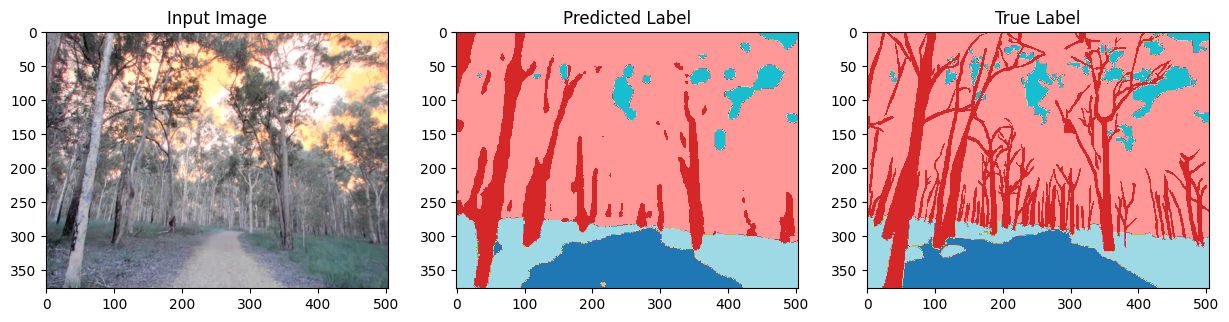

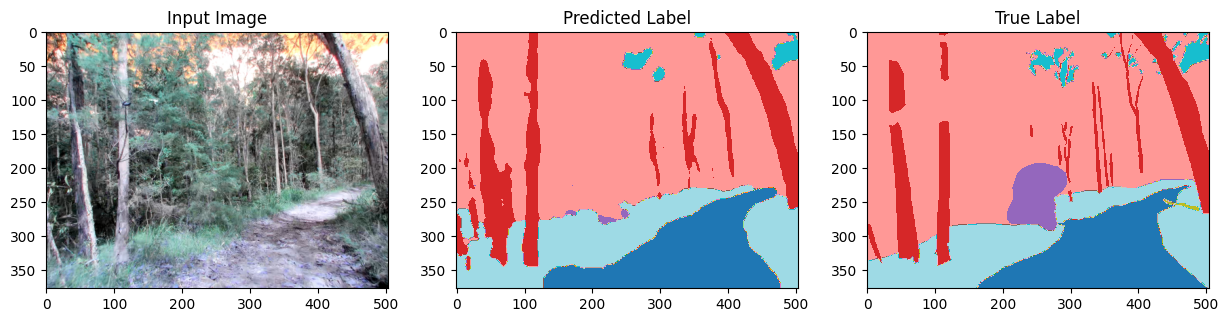

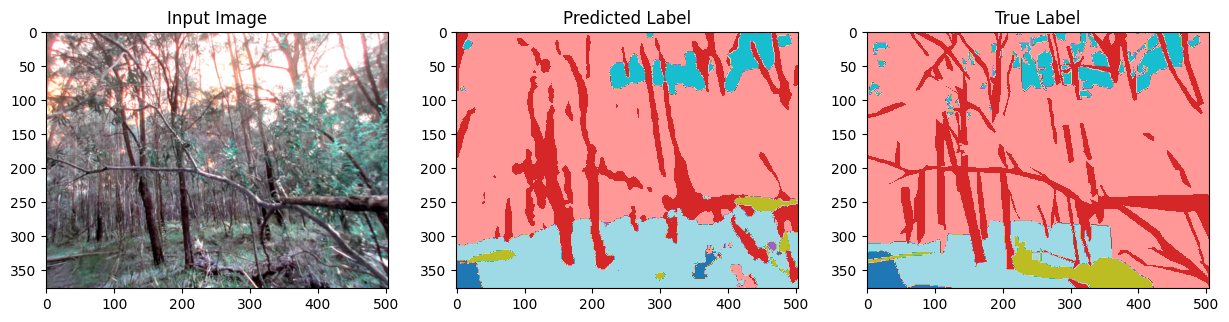

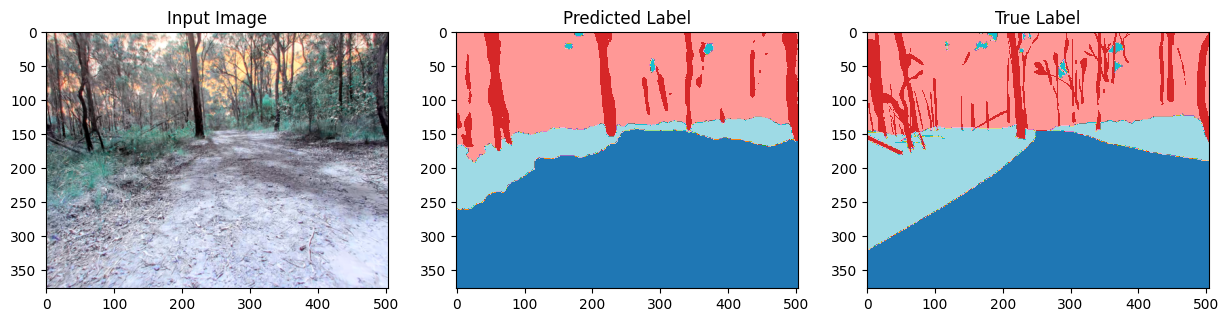

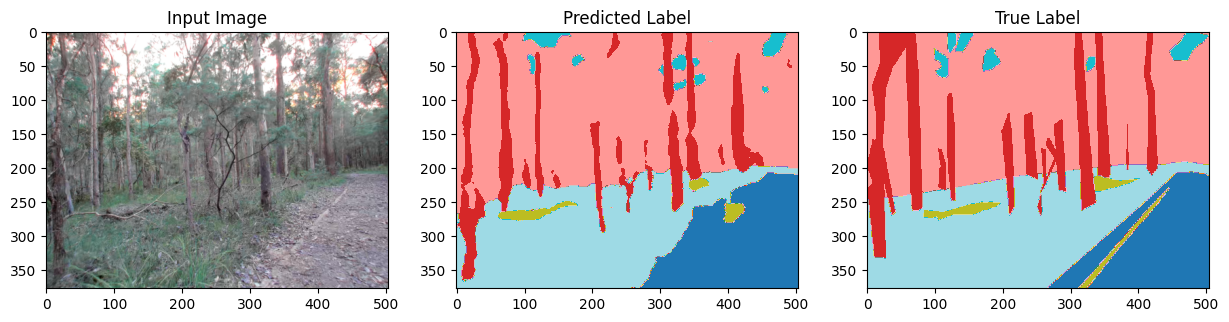

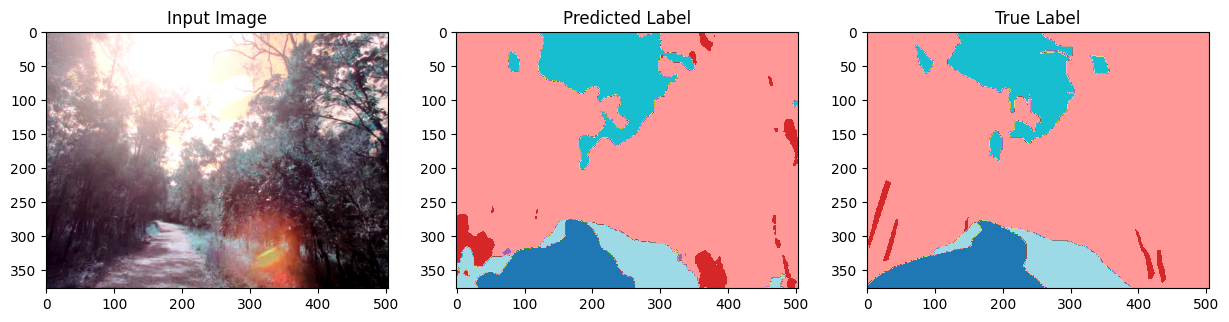

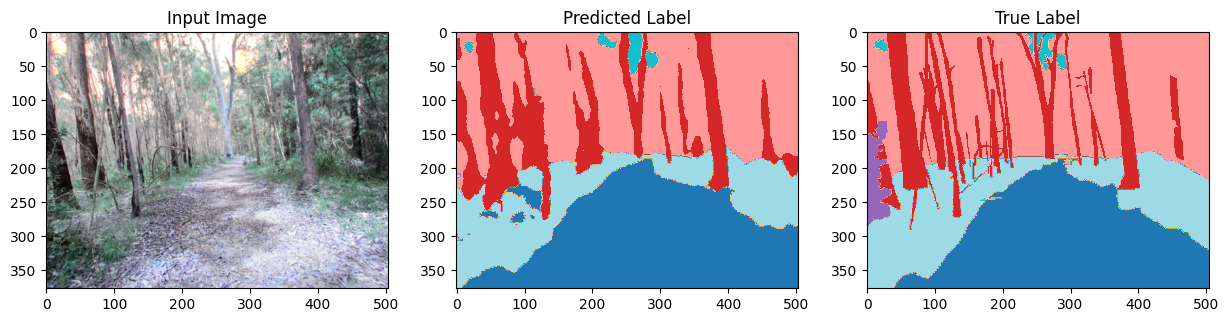

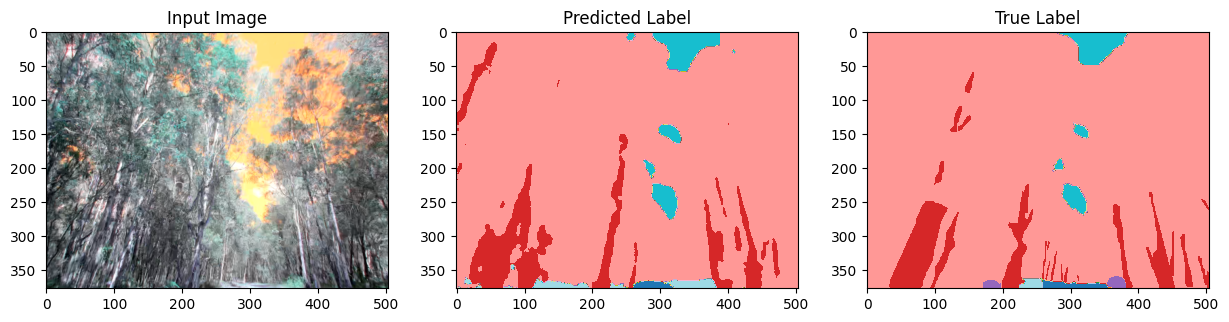

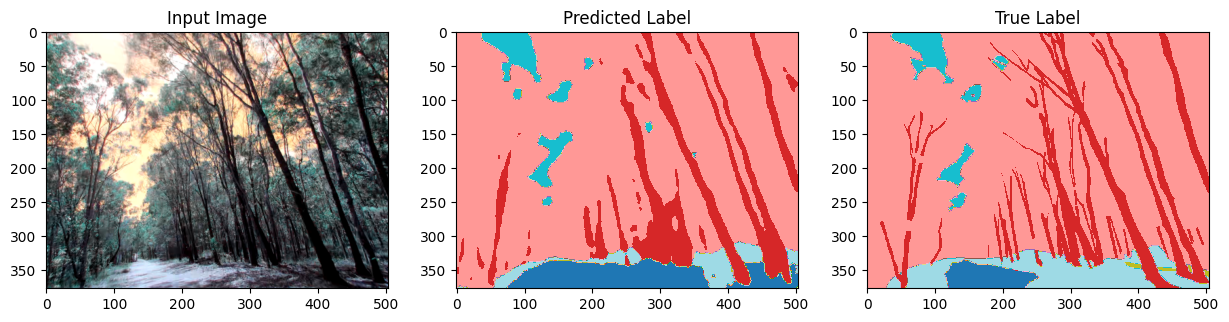

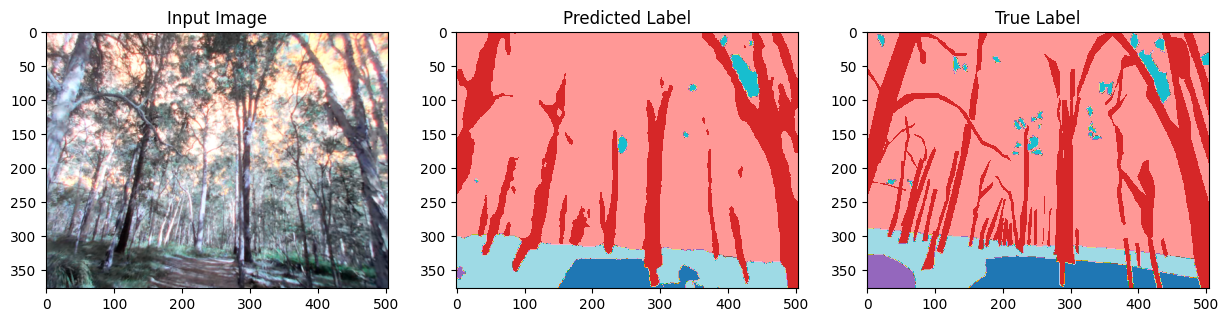

In [10]:
model.predict_and_display(test_loader, num_samples=10)